In [1]:
# IPython magic
from IPython.display import Image

# Predicting loan default using automated data wrangling

We will use the example of predicting loan default to practically walk you through a textbook data science problem and show how to use getML for automating the most tedious parts of the process and developing a production-ready solution in just a few hours - still beating most other models.

More concretely, you will use the getML Python API in order to

1. [Approach a real world dataset](#Data-preparation)
2. [Train a basic Pipeline](#Training-a-Pipeline)
3. [Perform a Hyperparameter optimization](#Hyperparameter-optimization)
4. [Interpret the trained features](#Studying-the-features)

If you wish to follow along the code sections in this tutorial, you can do so by downloading and installing [getML](https://getml.com/product). It's free.

**Introduction**

This tutorial features a use case from the financial sector. We will use getML in order to predict loan default. A loan is the lending of money to companies or individuals. Banks grant loans in exchange for the promise of repayment. Loan default is defined as the failure to meet this legal obligation, for example when a home buyer fails to make a mortgage payment. It is essential for a bank to estimate the risk it carries when granting loans to potentially non-performing customers.

The analysis is based on the [financial](https://relational.fit.cvut.cz/dataset/Financial) dataset from the [the CTU Prague Relational Learning Repository](https://arxiv.org/abs/1511.03086). It contains information about 606 successful and 76 not successful loans and consists of 8 tables:

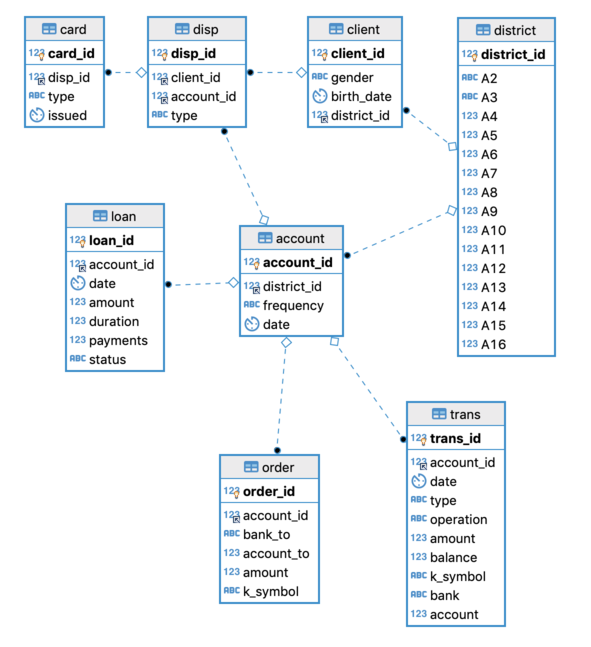

In [2]:
Image(filename="dataset_jupyter.png")

The `loan` table contains information about the loans granted by the bank, such as the date of creation, the amount, and the planned duration of the loan. It also contains the `status` of the loan. This is the target variable that we will predict in this analysis. The `loan` table is connected to the table `account` via the column `account_id`.

The `account` table contains further information about the accounts associated with each loan. Static characteristics such as the date of creation are contained in `account` and dynamic characteristics such as debited payments and balances are contained in `order` and `trans`. The table `client` includes characteristics of the account owners. Clients and accounts are related via the table `disp`. The `card` table describes credit card services the bank offers to its clients and is related to a certain account also via the table `disp`. The table `district` contains publicly available information such as the unemployment rate about the districts a certain account or client is related to. More information about the dataset can be found [here](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm). 

In the following, we will further explore the data and prepare a data model to be used for the analysis with getML. As usual, we start with setting a project.

In [3]:
import getml

import matplotlib.pyplot as plt
%matplotlib inline  

getml.engine.set_project('loans')

Creating new project 'loans'


Since the data sets from the CTU Prague Relational Learning Repository are available from a MariaDB database, we use getML's data base connector to directly load the data into the getML engine.

In [4]:
getml.database.connect_mysql(
    host="relational.fit.cvut.cz",
    port=3306,
    dbname="financial",
    user="guest",
    password="relational",
    time_formats=['%Y/%m/%d']
)

loan = getml.data.DataFrame.from_db('loan')
account = getml.data.DataFrame.from_db('account')
order = getml.data.DataFrame.from_db('order')
trans = getml.data.DataFrame.from_db('trans')
card = getml.data.DataFrame.from_db('card')
client = getml.data.DataFrame.from_db('client')
disp = getml.data.DataFrame.from_db('disp')
district = getml.data.DataFrame.from_db('district')

## Data preparation

We will have a closer look at the tables from the financial dataset and setup the data model. Note that a convenient way to explore the data frames we just loaded into the getML engine is to have a look at them in the [getML monitor](https://docs.getml.com/latest/user_guide/getml_suite/monitor/monitor.html). We recommend to check what is going on there in parallel to this tutorial.

### Setting roles

In order to tell getML feature learning algorithms how to treat the columns of each Data Frame we need to set its *role*. For more information about roles, check out the [user guide](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html#roles). The loan table looks like this:

In [5]:
loan

Name,loan_id,account_id,amount,duration,date,payments,status
Role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,4959,2,80952,24,1994-01-05,3373.00,A
1,4961,19,30276,12,1996-04-29,2523.00,B
2,4962,25,30276,12,1997-12-08,2523.00,A
3,4967,37,318480,60,1998-10-14,5308.00,D
4,4968,38,110736,48,1998-04-19,2307.00,C
,...,...,...,...,...,...,...
677,7294,11327,39168,24,1998-09-27,1632.00,C
678,7295,11328,280440,60,1998-07-18,4674.00,C
679,7304,11349,419880,60,1995-10-29,6998.00,C


Note that each column has role *unused_string* or *unused_float*. At this point, no column is included in the feature learning process. We will set the correct roles for each colum in the following.

The `status` column is our target variable. It contains 4 different categories: 

* A means that the contract finished, no problems,
* B means that the contract finished, loan not paid,
* C means that contract is running, OK so far,
* D means that the contract is running, but the client has already missed at least one payment

Before assigning it the role *target* we need to transform it to a numerical variable. We will consider A and C a successful loan and B and D a default.

In [6]:
default = ((loan['status'] == 'B') | (loan['status'] == 'D'))
loan.add(default, name='default', role='target')
loan['default'].sum()

SUM aggregation, value: 76.0.

The data set contains 76 defaulted loans out of 681 data points in total, which corresponds to roughly 10%. 

Next, we assign roles to the remaining columns in `loan`

* **join_key**: loan_id, account_id
* **time_stamp**: date
* **numerical**: amount, duration, payments

Note that the column `status`, which obviously contains a data leak, will not be considered by getML since we do not assign it a role.

In [7]:
loan.set_role(["account_id", "loan_id"], getml.data.roles.join_key)
loan.set_role(["date"], getml.data.roles.time_stamp)
loan.set_role(["amount", "duration", "payments"], getml.data.roles.numerical)

The `account` table looks like this:

In [8]:
account

Name,account_id,district_id,frequency,date
Role,unused_float,unused_float,unused_string,unused_string
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26
2,3,5,POPLATEK MESICNE,1997-07-07
3,4,12,POPLATEK MESICNE,1996-02-21
4,5,15,POPLATEK MESICNE,1997-05-30
,...,...,...,...
4495,11333,8,POPLATEK MESICNE,1994-05-26
4496,11349,1,POPLATEK TYDNE,1995-05-26
4497,11359,61,POPLATEK MESICNE,1994-10-01


We set roles, analogously to the `loan` table

In [9]:
account.set_role(["account_id", "district_id"], getml.data.roles.join_key)
account.set_role(["date"], getml.data.roles.time_stamp)
account.set_role(["frequency"], getml.data.roles.categorical)

### Population table

The population table is the main table of the analysis containing the statistical population and the target variable of the problem. Here it seems natural to chose `loan` as population table. This would lead to a quite [snowflake data data](https://docs.getml.com/develop/user_guide/data_model/data_model.html#the-snowflake-schema) with all peripheral tables being joined to `account`. Before implementing this data schema, however, let's have a closer look at the relation between `loans` and `account`:

In [10]:
print(loan['account_id'].count_distinct())
print(account['account_id'].count_distinct())

COUNT_DISTINCT aggregation, value: 682.0.
COUNT_DISTINCT aggregation, value: 4500.0.


The join key `account_id` has no duplicated value neither in `loan` nor in `account`. That means, each row in `loan` is associated with exactly one row in `account`. This is called a one-to-one relation.

It does not make sense to let getML's feature learning algorithms try to find aggregations over the accounts associated with each loan (because there is only one). So we perform the join operation between both tables before feeding them into getML. This is part of the definition of the data model and is generally recommended for one-to-one or many-to-one relations. The resulting table will be the population table of our analysis.

In [11]:
population = loan.join(
    name='population',
    other=account,
    how='left',
    join_key='account_id',
    other_cols=[
        account['district_id'],
        account['frequency'],
        account['date'].alias('date_account')
    ]
)

In [12]:
population

Name,date,date_account,account_id,loan_id,district_id,default,frequency,amount,duration,payments,status
Role,time_stamp,time_stamp,join_key,join_key,join_key,target,categorical,numerical,numerical,numerical,unused_string
Unit,"time stamp, comparison only","time stamp, comparison only",,,,,,,,,
0,1994-01-05T00:00:00.000000Z,1993-02-26T00:00:00.000000Z,2,4959,1,0,POPLATEK MESICNE,80952,24,3373,A
1,1996-04-29T00:00:00.000000Z,1995-04-07T00:00:00.000000Z,19,4961,21,1,POPLATEK MESICNE,30276,12,2523,B
2,1997-12-08T00:00:00.000000Z,1996-07-28T00:00:00.000000Z,25,4962,68,0,POPLATEK MESICNE,30276,12,2523,A
3,1998-10-14T00:00:00.000000Z,1997-08-18T00:00:00.000000Z,37,4967,20,1,POPLATEK MESICNE,318480,60,5308,D
4,1998-04-19T00:00:00.000000Z,1997-08-08T00:00:00.000000Z,38,4968,19,0,POPLATEK TYDNE,110736,48,2307,C
,...,...,...,...,...,...,...,...,...,...,...
677,1998-09-27T00:00:00.000000Z,1997-10-15T00:00:00.000000Z,11327,7294,7,0,POPLATEK MESICNE,39168,24,1632,C
678,1998-07-18T00:00:00.000000Z,1996-11-05T00:00:00.000000Z,11328,7295,54,0,POPLATEK MESICNE,280440,60,4674,C


We randomly split the data into a training and a validation set. We use 70% of the data set for training and the rest for testing.

In [13]:
split = 0.7
population_train = population.where('population_train', population.random() < split)
population_test = population.where('population_test', population.random() >= split)

### Peripheral tables

We will start simple and only consider the two peripheral tables order and trans

In [14]:
order

Name,order_id,account_id,account_to,bank_to,amount,k_symbol
Role,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,29401,1,87144583,YZ,2452.0,SIPO
1,29402,2,89597016,ST,3372.7,UVER
2,29403,2,13943797,QR,7266.0,SIPO
3,29404,3,83084338,WX,1135.0,SIPO
4,29405,3,24485939,CD,327.0,
,...,...,...,...,...,...
6466,46334,11362,70641225,YZ,4780.0,SIPO
6467,46335,11362,78507822,MN,56.0,
6468,46336,11362,40799850,ST,330.0,POJISTNE


In [15]:
order.set_role(["account_id"], getml.data.roles.join_key)
order.set_role(["amount"], getml.data.roles.numerical)
order.set_role(
    ["bank_to", "k_symbol", "account_to"], 
    getml.data.roles.categorical
)

In [16]:
trans

Name,trans_id,account_id,amount,balance,account,date,type,operation,k_symbol,bank
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,1,1000,1000,nan,1995-03-24,PRIJEM,VKLAD,NULL,NULL
1,5,1,3679,4679,41403269,1995-04-13,PRIJEM,PREVOD Z UCTU,NULL,AB
2,6,1,3679,20977,41403269,1995-05-13,PRIJEM,PREVOD Z UCTU,NULL,AB
3,7,1,3679,26835,41403269,1995-06-13,PRIJEM,PREVOD Z UCTU,NULL,AB
4,8,1,3679,30415,41403269,1995-07-13,PRIJEM,PREVOD Z UCTU,NULL,AB
,...,...,...,...,...,...,...,...,...,...
1056315,3682983,10451,62,17300,nan,1998-08-31,PRIJEM,NULL,UROK,NULL
1056316,3682984,10451,49,13442,nan,1998-09-30,PRIJEM,NULL,UROK,NULL
1056317,3682985,10451,34,10118,nan,1998-10-31,PRIJEM,NULL,UROK,NULL


In [17]:
trans.set_role(["account_id", "trans_id"], getml.data.roles.join_key)
trans.set_role(["date"], getml.data.roles.time_stamp)
trans.set_role(["amount", "balance"], getml.data.roles.numerical)
trans.set_role(
    ["type", "k_symbol", "bank","operation"], 
    getml.data.roles.categorical
)

### Setting units

There is one more thing we can do: We can also to tell the engine about the _unit_ for each column. Columns with the same unit will be directly compared during the feature learning process. For more information, check out the [user guide](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html#units).

In [18]:
population.set_unit(["amount"], 'money')
order.set_unit(["amount"], 'money')
trans.set_unit(["amount", "balance"], 'money')

### Data model

Now, we can define the data model. This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders). We create a Placeholder for each table in the data model. These placeholders are then joined together in order to define the data model we will then turn over to the engine.

In [19]:
population_placeholder = getml.data.Placeholder("population")
order_placeholder = getml.data.Placeholder("order")
trans_placeholder = getml.data.Placeholder("trans")

In [20]:
population_placeholder.join(order_placeholder,
                            join_key="account_id")

population_placeholder.join(trans_placeholder,
                            join_key="account_id", 
                            time_stamp="date")

The final data model looks like this

In [21]:
population_placeholder

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,time stamps used,upper time stamps used
population,order,False,0.0,account_id,0.0,account_id,,,
population,trans,False,0.0,account_id,0.0,account_id,date,date,


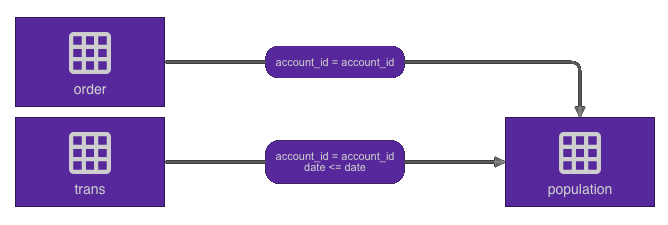

In [22]:
Image(filename="dataset2_jupyter.png")

## Training a Pipeline

After having prepared the dataset we can dive into the actual analysis. This is the point where getML sets in with automated feature learning and model training. We will train a [Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel) Model and a [Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost) Model in order to generated features and use [XGBoost](https://docs.getml.com/latest/api/getml.predictors.XGBoostClassifier.html#getml.predictors.XGBoostClassifier) in order to predict the target column `default`. These feature learners and the predictor are chained together with a feature selector in a getML Pipeline. We will start with the default settings for all hyperparameters and do an automated hyperparameter optimization later on.

In [23]:
feature_selector = getml.predictors.XGBoostClassifier(
    reg_lambda=500
)

predictor = getml.predictors.XGBoostClassifier(
    reg_lambda=500
)

In [24]:
agg = getml.feature_learning.aggregations

fl1 = getml.feature_learning.MultirelModel(
    aggregation=[
        agg.Avg,
        agg.Count,
        agg.Max,
        agg.Median,
        agg.Min,
        agg.Sum,
        agg.Var
    ],
    num_features=30,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1
)

fl2 = getml.feature_learning.RelboostModel(
    num_features=30,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1
)


In [25]:
pipe = getml.pipeline.Pipeline(
    tags=["baseline model"],
    population=population_placeholder,
    peripheral=[order_placeholder, trans_placeholder],
    feature_learners=[fl1, fl2],
    feature_selectors=feature_selector,
    predictors=predictor,
    share_selected_features=0.5
)

pipe

Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=False, 
         peripheral=['order', 'trans'], population='population', 
         predictors=['XGBoostClassifier'], tags=['baseline model'], 
         share_selected_features=0.5)

In order to check our data model on the actual training data we can _check_ the pipeline

In [26]:
pipe.check(
    population_table=population_train,
    peripheral_tables={"order": order, "trans": trans}
)

INFO [MIGHT TAKE LONG]: The number of unique entries in column 'account_to' in data frame 'order' is 6446. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: The ratio of unique entries to non-NULL entries in column 'account_to' in data frame 'order' is 99.613661%. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').


Checking data model...


We follow the advice we were given:

In [27]:
order.set_role("account_to", getml.data.roles.unused_string)

The next step is to fit the model using the training data set.

You can pass the peripheral tables by explicitly identifying the name of the placeholder, like this:

In [28]:
pipe = pipe.fit(
    population_table=population_train,
    peripheral_tables={"order": order, "trans": trans}
)

Checking data model...
OK.

Training features...
[========================================] 100%

Training features...
[========================================] 100%

Building features...
[========================================] 100%

Building features...
[========================================] 100%

Training XGBoost...
[========================================] 100%

Building features...
[========================================] 100%

Building features...
[========================================] 100%

Training XGBoost...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:29.604



You can also pass data like this. In this case, the peripheral tables need to be in the same order
as their corresponding placeholders.

Both ways of passing data work for `.check(...)`, `.fit(...)`, `.transform(...)`, `.predict(...)` and `.score(...)`.

In [29]:
pipe.fit(
    population_table=population_train,
    peripheral_tables=[order, trans],
)

Checking data model...
OK.

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.014882



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=False, 
         peripheral=['order', 'trans'], population='population', 
         predictors=['XGBoostClassifier'], tags=['baseline model'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/wLOdMD/0/

The training time of the model is below one minute.

Because we wanted to demonstrate the different methods of passing data, we actually ended up fitting two pipelines. But the second time we did this, the training process was much faster. This is because the getML pipelines have a functionality known as **dependency tracking**. For instance, if you change the hyperparameters of the predictor, the pipeline will figure out that nothing about the feature learner has changed, so it does not have to be refitted. In this case, we haven't changed anything at all, so nothing needs to be refitted. The pipeline just creates a copy of the previously fitted feature learners and predictors and that's it.

Let's look at how well the model performs on the validation dataset.

In [30]:
in_sample = pipe.score(
    population_table=population_train,
    peripheral_tables={"order": order, "trans": trans}
)

out_of_sample = pipe.score(
    population_table=population_test,
    peripheral_tables={"order": order, "trans": trans}
)

print("""
In sample accuracy: {:.2f}
In sample AUC: {:.2f}\n
Out of sample accuracy: {:.2f}
Out of sample AUC: {:.2f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0], 
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


Building features...
[========================================] 100%

Building features...
[========================================] 100%


Building features...
[========================================] 100%

Building features...
[========================================] 100%


In sample accuracy: 0.98
In sample AUC: 1.00

Out of sample accuracy: 0.96
Out of sample AUC: 0.91



This is already a promising result, but we can try to build on that by conducting a hyperparameter optimization.

## Hyperparameter optimization

We will perform a hyperparamter optimization to improve the out-of-sample accuracy. We will do this using a Bayesian hyperparameter optimization based on a Gaussian process.

To speed things up a little, we will only optimize the predictor. If we wanted to optimize the feature learners as well, we would just alter the `param_space`.

In [31]:
param_space = {
        "predictors": [
            {
                "max_depth": [3, 10],
                "reg_lambda": [0, 1000]
            }
        ]
}

In [32]:
gaussian_search = getml.hyperopt.GaussianHyperparameterSearch(
    pipeline=pipe,
    param_space=param_space,
    n_iter=50,
    score=getml.pipeline.scores.cross_entropy
)

gaussian_search = gaussian_search.fit(
    population_table_training=population_train,
    population_table_validation=population_test,
    peripheral_tables={"order": order, "trans": trans}
)


Checking data model...
OK.


In [33]:
best_pipeline = gaussian_search.best_pipeline

best_pipeline

Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=False, 
         peripheral=['order', 'trans'], population='population', 
         predictors=['XGBoostClassifier'], 
         tags=['baseline model', 'hyperopt-52AYdq'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/Slzwcu/0/

In [34]:
in_sample = best_pipeline.score(
    population_table=population_train,
    peripheral_tables={"order": order, "trans": trans}
)

out_of_sample = best_pipeline.score(
    population_table=population_test,
    peripheral_tables={"order": order, "trans": trans}
)

print("""
In sample accuracy: {:.2f}
In sample AUC: {:.2f}\n
Out of sample accuracy: {:.2f}
Out of sample AUC: {:.2f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0], 
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


Building features...
[========================================] 100%

Building features...
[========================================] 100%


Building features...
[========================================] 100%

Building features...
[========================================] 100%


In sample accuracy: 1.00
In sample AUC: 1.00

Out of sample accuracy: 0.96
Out of sample AUC: 0.92



## Studying the features

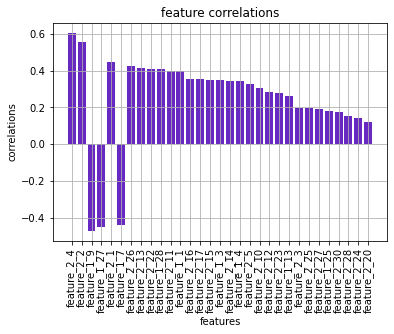

In [35]:
names, correlations = best_pipeline.features.correlations()

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

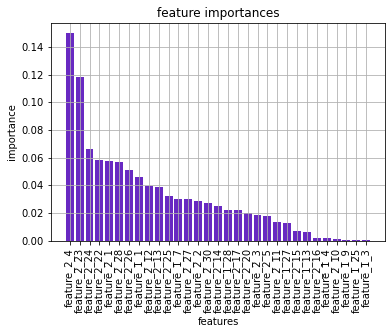

In [36]:
names, importances = best_pipeline.features.importances()

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

We will now look at the three most important features. Since the names are already sorted by importances

In [37]:
best_pipeline.features.to_sql()[names[0]]

```sql
CREATE TABLE "FEATURE_2_4" AS
SELECT AVG( 
    CASE
        WHEN ( t2."balance" > 10430.000000 ) AND ( t2."bank" IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN', 'OP' ) ) AND ( datetime( t1."date" ) > datetime( t2."date", '+32.951613 days' ) ) THEN -19.024116
        WHEN ( t2."balance" > 10430.000000 ) AND ( t2."bank" IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN', 'OP' ) ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+32.951613 days' ) OR t1."date" IS NULL OR t2."date" IS NULL ) THEN -32.262087
        WHEN ( t2."balance" > 10430.000000 ) AND ( t2."bank" NOT IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN', 'OP' ) ) AND ( t2."k_symbol" IN ( 'SIPO' ) ) THEN 32.559286
        WHEN ( t2."balance" > 10430.000000 ) AND ( t2."bank" NOT IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN', 'OP' ) ) AND ( t2."k_symbol" NOT IN ( 'SIPO' ) ) THEN -18.534438
        WHEN ( t2."balance" <= 10430.000000 OR t2."balance" IS NULL ) AND ( t2."balance" > 8451.000000 ) AND ( t2."bank" IN ( 'KL' ) ) THEN 394.075942
        WHEN ( t2."balance" <= 10430.000000 OR t2."balance" IS NULL ) AND ( t2."balance" > 8451.000000 ) AND ( t2."bank" NOT IN ( 'KL' ) ) THEN -32.813926
        WHEN ( t2."balance" <= 10430.000000 OR t2."balance" IS NULL ) AND ( t2."balance" <= 8451.000000 OR t2."balance" IS NULL ) AND ( datetime( t1."date" ) > datetime( t2."date", '+31.086957 days' ) ) THEN -0.130672
        WHEN ( t2."balance" <= 10430.000000 OR t2."balance" IS NULL ) AND ( t2."balance" <= 8451.000000 OR t2."balance" IS NULL ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+31.086957 days' ) OR t1."date" IS NULL OR t2."date" IS NULL ) THEN 39.412646
        ELSE NULL
    END
) AS "feature_2_4",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "trans" t2
ON t1."account_id" = t2."account_id"
WHERE datetime( t2."date" ) <= datetime( t1."date" )
GROUP BY t1.rowid;
```

In [38]:
best_pipeline.features.to_sql()[names[1]]

```sql
CREATE TABLE "FEATURE_2_23" AS
SELECT SUM( 
    CASE
        WHEN ( t2."balance" > 10391.000000 ) AND ( datetime( t1."date" ) > datetime( t2."date", '+4.604027 days' ) ) AND ( t2."bank" IN ( 'YZ', 'ST', 'WX', 'UV', 'GH', 'IJ' ) ) THEN -0.056499
        WHEN ( t2."balance" > 10391.000000 ) AND ( datetime( t1."date" ) > datetime( t2."date", '+4.604027 days' ) ) AND ( t2."bank" NOT IN ( 'YZ', 'ST', 'WX', 'UV', 'GH', 'IJ' ) ) THEN -0.001493
        WHEN ( t2."balance" > 10391.000000 ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+4.604027 days' ) OR t1."date" IS NULL OR t2."date" IS NULL ) AND ( t2."balance" > 117056.000000 ) THEN 0.968505
        WHEN ( t2."balance" > 10391.000000 ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+4.604027 days' ) OR t1."date" IS NULL OR t2."date" IS NULL ) AND ( t2."balance" <= 117056.000000 OR t2."balance" IS NULL ) THEN -0.422610
        WHEN ( t2."balance" <= 10391.000000 OR t2."balance" IS NULL ) AND ( t2."amount" > 9072.000000 ) AND ( datetime( t1."date_account" ) > datetime( t2."date", '-161.750000 days' ) ) THEN 2.368417
        WHEN ( t2."balance" <= 10391.000000 OR t2."balance" IS NULL ) AND ( t2."amount" > 9072.000000 ) AND ( datetime( t1."date_account" ) <= datetime( t2."date", '-161.750000 days' ) OR t1."date_account" IS NULL OR t2."date" IS NULL ) THEN 0.434576
        WHEN ( t2."balance" <= 10391.000000 OR t2."balance" IS NULL ) AND ( t2."amount" <= 9072.000000 OR t2."amount" IS NULL ) AND ( datetime( t1."date" ) > datetime( t2."date", '+240.230769 days' ) ) THEN -0.267587
        WHEN ( t2."balance" <= 10391.000000 OR t2."balance" IS NULL ) AND ( t2."amount" <= 9072.000000 OR t2."amount" IS NULL ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+240.230769 days' ) OR t1."date" IS NULL OR t2."date" IS NULL ) THEN 0.054699
        ELSE NULL
    END
) AS "feature_2_23",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "trans" t2
ON t1."account_id" = t2."account_id"
WHERE datetime( t2."date" ) <= datetime( t1."date" )
GROUP BY t1.rowid;
```

In [39]:
best_pipeline.features.to_sql()[names[2]]

```sql
CREATE TABLE "FEATURE_2_24" AS
SELECT SUM( 
    CASE
        WHEN ( t2."k_symbol" IN ( 'SIPO', 'UVER' ) ) AND ( t2."bank_to" IN ( 'YZ', 'QR', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN' ) ) AND ( t2."bank_to" IN ( 'MN' ) ) THEN -0.580210
        WHEN ( t2."k_symbol" IN ( 'SIPO', 'UVER' ) ) AND ( t2."bank_to" IN ( 'YZ', 'QR', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN' ) ) AND ( t2."bank_to" NOT IN ( 'MN' ) ) THEN -1.473239
        WHEN ( t2."k_symbol" IN ( 'SIPO', 'UVER' ) ) AND ( t2."bank_to" NOT IN ( 'YZ', 'QR', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN' ) ) AND ( t1."amount" > 66831.000000 ) THEN -0.974030
        WHEN ( t2."k_symbol" IN ( 'SIPO', 'UVER' ) ) AND ( t2."bank_to" NOT IN ( 'YZ', 'QR', 'CD', 'AB', 'UV', 'GH', 'IJ', 'KL', 'EF', 'MN' ) ) AND ( t1."amount" <= 66831.000000 OR t1."amount" IS NULL ) THEN 0.546624
        WHEN ( t2."k_symbol" NOT IN ( 'SIPO', 'UVER' ) ) AND ( t1."amount" > 251201.000000 ) AND ( t2."bank_to" IN ( 'YZ', 'AB', 'UV', 'GH', 'IJ' ) ) THEN 0.148710
        WHEN ( t2."k_symbol" NOT IN ( 'SIPO', 'UVER' ) ) AND ( t1."amount" > 251201.000000 ) AND ( t2."bank_to" NOT IN ( 'YZ', 'AB', 'UV', 'GH', 'IJ' ) ) THEN 1.784858
        WHEN ( t2."k_symbol" NOT IN ( 'SIPO', 'UVER' ) ) AND ( t1."amount" <= 251201.000000 OR t1."amount" IS NULL ) AND ( t2."bank_to" IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'KL', 'MN', 'OP' ) ) THEN -0.059465
        WHEN ( t2."k_symbol" NOT IN ( 'SIPO', 'UVER' ) ) AND ( t1."amount" <= 251201.000000 OR t1."amount" IS NULL ) AND ( t2."bank_to" NOT IN ( 'YZ', 'ST', 'QR', 'WX', 'CD', 'AB', 'UV', 'KL', 'MN', 'OP' ) ) THEN 1.069774
        ELSE NULL
    END
) AS "feature_2_24",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "order" t2
ON t1."account_id" = t2."account_id"
GROUP BY t1.rowid;
```

 You can see the logic behind the aggregation, but its also clear that it would have been impossible to come up with the specific values by hand or using brute force approaches.

## Results

We are able to predict loan default in the example dataset with a very good AUC. With this result getML is in the top 1% of [published](https://relational.fit.cvut.cz/dataset/Financial) solutions on this problem. The training time for the initial model was less than one minute. Altogether, this project can easily be completed within one day.

You can use this tutorial as starting point for your own analysis or head over the other tutorials and the [user guide](https://docs.getml.com) if you want to learn more about the functionality getML offers. Please [contact us](https://get.ml/contact/lets-talk) to give us feedback about this tutorial or general inquiries.

You can also [download getML for free](https://getml.com/product).